## Path Parameters

In [1]:
import os

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_DIR = os.path.abspath("../models/")
DATASET_DIR= os.path.abspath("../dataset_manga/")
DEFAULT_LOGS_DIR = MODEL_DIR

print(f"Root: {ROOT_DIR}")
print(f"Models: {MODEL_DIR}")
print(f"Dataset: {DATASET_DIR}")

## Imports

In [2]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime

import skimage.draw
import cv2
import glob

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.model import log
from mrcnn import model as modellib, utils

import tensorflow
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)

%matplotlib inline 

c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

## Dataset

In [3]:
class BubblesDataset(utils.Dataset):
    
    def load_shapes(self, subset):
        self.subset= subset
        self.add_class("bubbles", 1, "bubble")
            
        filelist= os.listdir(os.path.join(DATASET_DIR, subset, 'images'))
        for file in filelist:
            if ".png" not in file and ".jpg" not in file:
                continue
            image_path = os.path.join(DATASET_DIR, subset, 'images', file)
            try:
                image = skimage.io.imread(image_path)
            except Exception as e:
                print(image_path)
                print(e)
            height, width = image.shape[:2]
            
            #print(f'file {file}')
            self.add_image(
                "bubbles",
                image_id=file,
                name=file,
                path= os.path.join(DATASET_DIR, subset, 'images', file),
                width=width, height=height)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        
        fdir= DATASET_DIR + "/" + self.subset + "/masks/" + image_info["name"][:-4]
        if not (os.path.exists(fdir)):
            print(fdir)
            assert(os.path.exists(fdir))
        
        
        ids=[]
        masks= []
        for file in glob.glob(fdir + "/*.png"):
            if len(masks)!=0:
                img = cv2.imread(file, 0).astype(np.bool)
                #print(file, masks.shape, img.shape)
                masks= np.dstack((masks, img))
                ids.append(1)
            else:
                masks= cv2.imread(file, 0).astype(np.bool)
                ids.append(1)
        
        if len(masks.shape) < 3:
            masks= np.expand_dims(masks, axis=2)
        return masks, np.ones(len(ids), dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "bubbles":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
    def load_image(self, image_id):
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 1:
            image = skimage.color.rgb2gray(image)
        image = image[..., np.newaxis]
        #print(image.shape, " ", self.image_info[image_id]['path'])
        return image

## Training Parameters

In [4]:
class BubblesConfig(Config):    
    BACKBONE= 'resnet50'

    IMAGE_RESIZE_MODE='crop'
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    
    STEPS_PER_EPOCH= 1000
    EPOCHS= 5
    
    IMAGE_CHANNEL_COUNT= 1
    MEAN_PIXEL= np.array([123.7])
    
    TRAIN_ROIS_PER_IMAGE = 30
    
    
    #Blech
    NAME = "bubbles"
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = BubblesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1024 1024    1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

In [5]:
dataset_train = BubblesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()
print(len(dataset_train.image_ids), 'training images')

dataset_val = BubblesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()
print(len(dataset_val.image_ids), 'validation images')

436 training images
41 validation images


In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 6


## Training

In [11]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=8,
            layers='all')


Starting at epoch 6. LR=0.001

Checkpoint Path: C:\Programming\Bubbles\models\bubbles20190907T1915\mask_rcnn_bubbles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 7/8
1000/1000 [==============================] - 1584s 2s/step - loss: 1.5362 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.3619 - val_loss: 1.2128 - val_rpn_class_loss: 0.0736 - val_rpn_bbox_loss: 0.4151 - val_mrcnn_class_loss: 0.1703 - val_mrcnn_bbox_loss: 0.2452 - val_mrcnn_mask_loss: 0.3086
Epoch 8/8
1000/1000 [==============================] - 1572s 2s/step - loss: 1.5534 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.3539 - val_loss: 0.9283 - val_rpn_class_loss: 0.0444 - val_rpn_bbox_loss: 0.3098 - val_mrcnn_class_loss: 0.1423 - val_mrcnn_bbox_loss: 0.2100 - val_mrcnn_mask_loss: 0.2217


## Detection

In [21]:
class InferenceConfig(BubblesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE= .98

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Programming\Bubbles\models\bubbles20190907T1915\mask_rcnn_bubbles_0008.h5
Re-starting from epoch 8


(1024, 1024, 3)
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1600.00000  int32
gt_class_id              shape: (0,)                  min:             max:             int32
gt_bbox                  shape: (0, 4)                min:             max:             int32
gt_mask                  shape: (1024, 1024, 0)       min:             max:             bool

*** No instances to display *** 



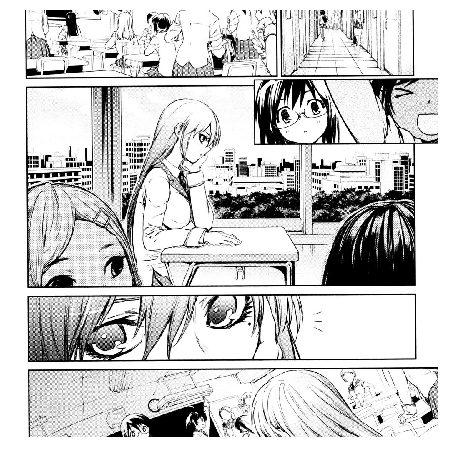

In [22]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

disp_image= np.concatenate((original_image, original_image, original_image),axis=2)
print(disp_image.shape)

log("original_image", disp_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(disp_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 1)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


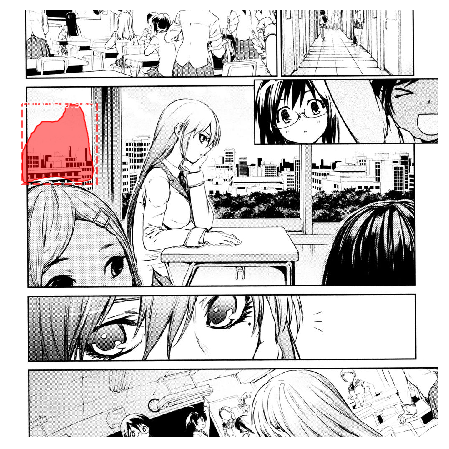

In [23]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4752976208925247
